# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Neural Network class

* Generator
* Discriminator


In [5]:
# Generator Network
class Generator(nn.Module):

    # declare generator layers
    def __init__(self):
      super(Generator, self).__init__()
      # one linear layer with 20 input nodes and 400 output nodes
      self.linear1 = nn.Linear(20, 400)
      # one linear layer with 400 input nodes and 784 output nodes
      self.linear2 = nn.Linear(400, 784)


    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        # one ReLU hidden layer of 400 nodes
        x = F.relu(self.linear1(z))
        # one Sigmoid output layer of 784 nodes
        output = torch.sigmoid(self.linear2(x))
        return output


# Discriminator Network
class Discriminator(nn.Module):

    # declare discriminator layers
    def __init__(self):
        super(Discriminator, self).__init__()
        # one linear layer with 784 input nodes and 400 output nodes
        self.linear1 = nn.Linear(784, 400)
        # one linear layer with 400 input nodes and 1 output node
        self.linear2 = nn.Linear(400, 1)

    
    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        # one ReLU hidden layer of 400 nodes
        x = F.relu(self.linear1(x))
        # one Sigmoid output layer of 1 node
        output = torch.sigmoid(self.linear2(x))
        return output
    


# Loss Function

In [6]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):
    # create a tensor of the same shape as predictions with values of either 1 or 0
    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [8]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    # set networks to training mode
    generator.train()
    discriminator.train()
    average_generator_loss = 0
    average_discriminator_loss = 0
    # iterate over the training data
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # reshape data
        data = data.view(-1, 784)
        data, target = data.to(device), target.to(device)
        
        # zero the parameter gradients
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        
        # generate fake images
        z = torch.randn(batch_size, 20).to(device)
        fake_images = generator(z)
        
        # train discriminator on real images
        real_predictions = discriminator(data)
        real_targets = torch.ones(batch_size, 1).to(device)
        if data.shape[0] != batch_size:
            break
        real_loss = F.binary_cross_entropy(real_predictions, real_targets, reduction='sum')
        
        # train discriminator on fake images
        fake_predictions = discriminator(fake_images)
        fake_targets = torch.zeros(batch_size, 1).to(device)
        fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets, reduction='sum')
        
        # backpropagate discriminator loss
        discriminator_loss = real_loss + fake_loss
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        # train generator
        z = torch.randn(batch_size, 20).to(device)
        fake_images = generator(z)
        fake_predictions = discriminator(fake_images)
        fake_targets = torch.ones(batch_size, 1).to(device)
        generator_loss = F.binary_cross_entropy(fake_predictions, fake_targets, reduction='sum')
        
        # backpropagate generator loss
        generator_loss.backward()
        generator_optimizer.step()
        
        # print statistics
        average_generator_loss += generator_loss.item()
        average_discriminator_loss += discriminator_loss.item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tGenerator Loss: {:.6f}\tDiscriminator Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                generator_loss.item() / len(data), discriminator_loss.item() / len(data)))
    
    # calculate the average generator and discriminator loss
    average_generator_loss /= len(train_loader.dataset)
    average_discriminator_loss /= len(train_loader.dataset)
    
    return average_generator_loss, average_discriminator_loss
    

# Testing


In [11]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    # set networks to evaluation mode
    generator.eval()
    discriminator.eval()
    average_generator_loss = 0
    average_discriminator_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # reshape data
            data = data.view(-1, 784)
            # move data to GPU
            data, target = data.to(device), target.to(device)
            # generate fake images
            z = torch.randn(batch_size, 20).to(device)
            fake_images = generator(z)
            # test discriminator on real images
            real_predictions = discriminator(data)
            if data.shape[0] != batch_size:
                break
            real_targets = torch.ones(batch_size, 1).to(device)
            real_loss = gan_loss_function(real_predictions, real_targets)
            # test discriminator on fake images
            fake_predictions = discriminator(fake_images)
            fake_targets = torch.zeros(batch_size, 1).to(device)
            fake_loss = gan_loss_function(fake_predictions, fake_targets)
            # compute discriminator loss
            discriminator_loss = real_loss + fake_loss
            # test generator
            z = torch.randn(batch_size, 20).to(device)
            fake_images = generator(z)
            fake_predictions = discriminator(fake_images)
            fake_targets = torch.ones(batch_size, 1).to(device)
            generator_loss = gan_loss_function(fake_predictions, fake_targets)
            # print statistics
            average_generator_loss += generator_loss.item()
            average_discriminator_loss += discriminator_loss.item()
            if batch_idx % log_interval == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tGenerator Loss: {:.6f}\tDiscriminator Loss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(test_loader.dataset),
                    20. * batch_idx / len(test_loader),
                    generator_loss.item() / len(data), discriminator_loss.item() / len(data)))
    average_generator_loss /= len(test_loader.dataset)
    average_discriminator_loss /= len(test_loader.dataset)
    return average_generator_loss, average_discriminator_loss

# Main

Train Epoch: 1 [0/60000 (0%)]	Generator Loss: 1.903302	Discriminator Loss: 1.338483
Train Epoch: 1 [12800/60000 (21%)]	Generator Loss: 3.801025	Discriminator Loss: 0.181211
Train Epoch: 1 [25600/60000 (43%)]	Generator Loss: 5.969584	Discriminator Loss: 0.013677
Train Epoch: 1 [38400/60000 (64%)]	Generator Loss: 5.571687	Discriminator Loss: 0.065738
Train Epoch: 1 [51200/60000 (85%)]	Generator Loss: 7.360634	Discriminator Loss: 0.002924
Test Epoch: 1 [0/10000 (0%)]	Generator Loss: 6.744952	Discriminator Loss: 0.010776
Sample of generated images


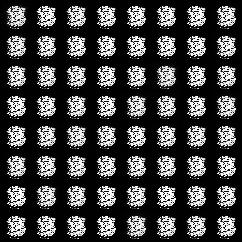



Train Epoch: 2 [0/60000 (0%)]	Generator Loss: 7.913406	Discriminator Loss: 0.009071
Train Epoch: 2 [12800/60000 (21%)]	Generator Loss: 8.711840	Discriminator Loss: 0.003937
Train Epoch: 2 [25600/60000 (43%)]	Generator Loss: 7.638000	Discriminator Loss: 0.005533
Train Epoch: 2 [38400/60000 (64%)]	Generator Loss: 5.422362	Discriminator Loss: 0.030359
Train Epoch: 2 [51200/60000 (85%)]	Generator Loss: 6.541693	Discriminator Loss: 0.017720
Test Epoch: 2 [0/10000 (0%)]	Generator Loss: 6.229247	Discriminator Loss: 0.012947
Sample of generated images


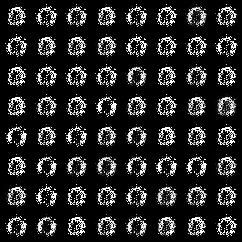



Train Epoch: 3 [0/60000 (0%)]	Generator Loss: 6.800968	Discriminator Loss: 0.015125
Train Epoch: 3 [12800/60000 (21%)]	Generator Loss: 8.217152	Discriminator Loss: 0.013394
Train Epoch: 3 [25600/60000 (43%)]	Generator Loss: 8.670954	Discriminator Loss: 0.027341
Train Epoch: 3 [38400/60000 (64%)]	Generator Loss: 6.273574	Discriminator Loss: 0.024715
Train Epoch: 3 [51200/60000 (85%)]	Generator Loss: 7.230731	Discriminator Loss: 0.010764
Test Epoch: 3 [0/10000 (0%)]	Generator Loss: 6.874733	Discriminator Loss: 0.007438
Sample of generated images


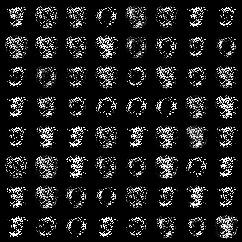



Train Epoch: 4 [0/60000 (0%)]	Generator Loss: 7.220836	Discriminator Loss: 0.019217
Train Epoch: 4 [12800/60000 (21%)]	Generator Loss: 6.301917	Discriminator Loss: 0.029554
Train Epoch: 4 [25600/60000 (43%)]	Generator Loss: 6.765447	Discriminator Loss: 0.019458
Train Epoch: 4 [38400/60000 (64%)]	Generator Loss: 6.898061	Discriminator Loss: 0.010290
Train Epoch: 4 [51200/60000 (85%)]	Generator Loss: 6.853016	Discriminator Loss: 0.025869
Test Epoch: 4 [0/10000 (0%)]	Generator Loss: 6.432961	Discriminator Loss: 0.050659
Sample of generated images


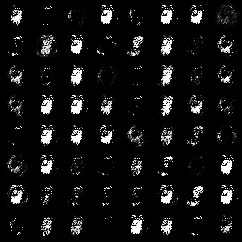



Train Epoch: 5 [0/60000 (0%)]	Generator Loss: 7.238903	Discriminator Loss: 0.040142
Train Epoch: 5 [12800/60000 (21%)]	Generator Loss: 7.531092	Discriminator Loss: 0.037510
Train Epoch: 5 [25600/60000 (43%)]	Generator Loss: 6.849877	Discriminator Loss: 0.026568
Train Epoch: 5 [38400/60000 (64%)]	Generator Loss: 6.272841	Discriminator Loss: 0.032478
Train Epoch: 5 [51200/60000 (85%)]	Generator Loss: 6.127702	Discriminator Loss: 0.016665
Test Epoch: 5 [0/10000 (0%)]	Generator Loss: 5.641500	Discriminator Loss: 0.024537
Sample of generated images


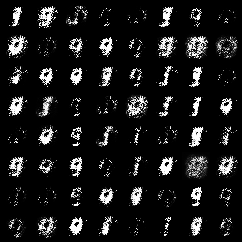



Train Epoch: 6 [0/60000 (0%)]	Generator Loss: 6.362622	Discriminator Loss: 0.021255
Train Epoch: 6 [12800/60000 (21%)]	Generator Loss: 6.107114	Discriminator Loss: 0.037140
Train Epoch: 6 [25600/60000 (43%)]	Generator Loss: 6.849640	Discriminator Loss: 0.072328
Train Epoch: 6 [38400/60000 (64%)]	Generator Loss: 6.645874	Discriminator Loss: 0.072989
Train Epoch: 6 [51200/60000 (85%)]	Generator Loss: 6.230608	Discriminator Loss: 0.036293
Test Epoch: 6 [0/10000 (0%)]	Generator Loss: 5.731127	Discriminator Loss: 0.061322
Sample of generated images


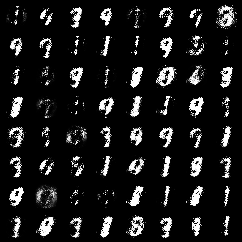



Train Epoch: 7 [0/60000 (0%)]	Generator Loss: 7.045139	Discriminator Loss: 0.035385
Train Epoch: 7 [12800/60000 (21%)]	Generator Loss: 8.607584	Discriminator Loss: 0.124094
Train Epoch: 7 [25600/60000 (43%)]	Generator Loss: 6.990677	Discriminator Loss: 0.064341
Train Epoch: 7 [38400/60000 (64%)]	Generator Loss: 7.370256	Discriminator Loss: 0.096739
Train Epoch: 7 [51200/60000 (85%)]	Generator Loss: 6.373397	Discriminator Loss: 0.031040
Test Epoch: 7 [0/10000 (0%)]	Generator Loss: 5.453749	Discriminator Loss: 0.092318
Sample of generated images


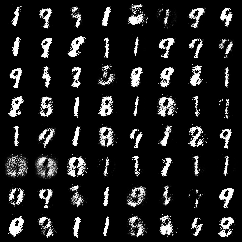



Train Epoch: 8 [0/60000 (0%)]	Generator Loss: 5.519135	Discriminator Loss: 0.048506
Train Epoch: 8 [12800/60000 (21%)]	Generator Loss: 6.693876	Discriminator Loss: 0.060074
Train Epoch: 8 [25600/60000 (43%)]	Generator Loss: 6.279586	Discriminator Loss: 0.086805
Train Epoch: 8 [38400/60000 (64%)]	Generator Loss: 5.299335	Discriminator Loss: 0.121120
Train Epoch: 8 [51200/60000 (85%)]	Generator Loss: 5.088387	Discriminator Loss: 0.136116
Test Epoch: 8 [0/10000 (0%)]	Generator Loss: 5.637175	Discriminator Loss: 0.150627
Sample of generated images


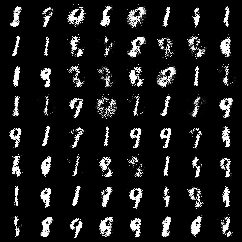



Train Epoch: 9 [0/60000 (0%)]	Generator Loss: 6.554152	Discriminator Loss: 0.141101
Train Epoch: 9 [12800/60000 (21%)]	Generator Loss: 4.246140	Discriminator Loss: 0.155038
Train Epoch: 9 [25600/60000 (43%)]	Generator Loss: 6.353297	Discriminator Loss: 0.131951
Train Epoch: 9 [38400/60000 (64%)]	Generator Loss: 5.268885	Discriminator Loss: 0.220096
Train Epoch: 9 [51200/60000 (85%)]	Generator Loss: 5.172168	Discriminator Loss: 0.148864
Test Epoch: 9 [0/10000 (0%)]	Generator Loss: 5.985476	Discriminator Loss: 0.141257
Sample of generated images


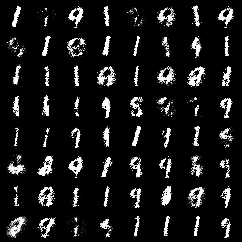



Train Epoch: 10 [0/60000 (0%)]	Generator Loss: 6.459903	Discriminator Loss: 0.108265
Train Epoch: 10 [12800/60000 (21%)]	Generator Loss: 5.793779	Discriminator Loss: 0.149210
Train Epoch: 10 [25600/60000 (43%)]	Generator Loss: 5.575815	Discriminator Loss: 0.221447
Train Epoch: 10 [38400/60000 (64%)]	Generator Loss: 5.855649	Discriminator Loss: 0.104667
Train Epoch: 10 [51200/60000 (85%)]	Generator Loss: 5.172083	Discriminator Loss: 0.146637
Test Epoch: 10 [0/10000 (0%)]	Generator Loss: 4.973323	Discriminator Loss: 0.103799
Sample of generated images


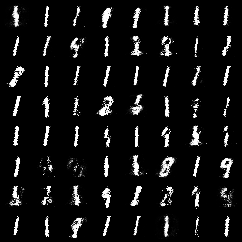



Train Epoch: 11 [0/60000 (0%)]	Generator Loss: 5.383407	Discriminator Loss: 0.154862
Train Epoch: 11 [12800/60000 (21%)]	Generator Loss: 5.210008	Discriminator Loss: 0.100227
Train Epoch: 11 [25600/60000 (43%)]	Generator Loss: 4.962067	Discriminator Loss: 0.175706
Train Epoch: 11 [38400/60000 (64%)]	Generator Loss: 4.875287	Discriminator Loss: 0.140447
Train Epoch: 11 [51200/60000 (85%)]	Generator Loss: 4.551679	Discriminator Loss: 0.198108
Test Epoch: 11 [0/10000 (0%)]	Generator Loss: 3.905330	Discriminator Loss: 0.214826
Sample of generated images


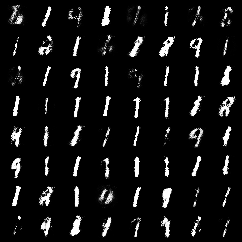



Train Epoch: 12 [0/60000 (0%)]	Generator Loss: 3.706748	Discriminator Loss: 0.187790
Train Epoch: 12 [12800/60000 (21%)]	Generator Loss: 4.346902	Discriminator Loss: 0.174640
Train Epoch: 12 [25600/60000 (43%)]	Generator Loss: 3.815923	Discriminator Loss: 0.134763
Train Epoch: 12 [38400/60000 (64%)]	Generator Loss: 3.626394	Discriminator Loss: 0.272291
Train Epoch: 12 [51200/60000 (85%)]	Generator Loss: 4.273247	Discriminator Loss: 0.392532
Test Epoch: 12 [0/10000 (0%)]	Generator Loss: 3.407157	Discriminator Loss: 0.273268
Sample of generated images


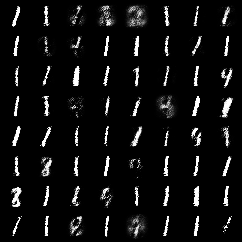



Train Epoch: 13 [0/60000 (0%)]	Generator Loss: 3.224528	Discriminator Loss: 0.240112
Train Epoch: 13 [12800/60000 (21%)]	Generator Loss: 5.041121	Discriminator Loss: 0.203267
Train Epoch: 13 [25600/60000 (43%)]	Generator Loss: 4.174188	Discriminator Loss: 0.236237
Train Epoch: 13 [38400/60000 (64%)]	Generator Loss: 4.235782	Discriminator Loss: 0.278346
Train Epoch: 13 [51200/60000 (85%)]	Generator Loss: 4.286430	Discriminator Loss: 0.198883
Test Epoch: 13 [0/10000 (0%)]	Generator Loss: 3.813000	Discriminator Loss: 0.226468
Sample of generated images


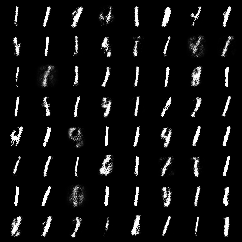



Train Epoch: 14 [0/60000 (0%)]	Generator Loss: 3.926007	Discriminator Loss: 0.251561
Train Epoch: 14 [12800/60000 (21%)]	Generator Loss: 4.593499	Discriminator Loss: 0.201626
Train Epoch: 14 [25600/60000 (43%)]	Generator Loss: 4.055577	Discriminator Loss: 0.408223
Train Epoch: 14 [38400/60000 (64%)]	Generator Loss: 4.979594	Discriminator Loss: 0.298949
Train Epoch: 14 [51200/60000 (85%)]	Generator Loss: 4.689413	Discriminator Loss: 0.273953
Test Epoch: 14 [0/10000 (0%)]	Generator Loss: 3.045024	Discriminator Loss: 0.296823
Sample of generated images


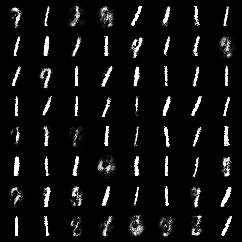



Train Epoch: 15 [0/60000 (0%)]	Generator Loss: 3.416581	Discriminator Loss: 0.337600
Train Epoch: 15 [12800/60000 (21%)]	Generator Loss: 3.485756	Discriminator Loss: 0.165050
Train Epoch: 15 [25600/60000 (43%)]	Generator Loss: 3.480958	Discriminator Loss: 0.199724
Train Epoch: 15 [38400/60000 (64%)]	Generator Loss: 3.271473	Discriminator Loss: 0.315579
Train Epoch: 15 [51200/60000 (85%)]	Generator Loss: 3.282152	Discriminator Loss: 0.341231
Test Epoch: 15 [0/10000 (0%)]	Generator Loss: 3.541088	Discriminator Loss: 0.268426
Sample of generated images


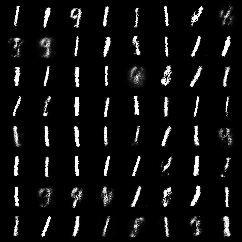



Train Epoch: 16 [0/60000 (0%)]	Generator Loss: 4.233390	Discriminator Loss: 0.238247
Train Epoch: 16 [12800/60000 (21%)]	Generator Loss: 3.929043	Discriminator Loss: 0.383361
Train Epoch: 16 [25600/60000 (43%)]	Generator Loss: 3.259435	Discriminator Loss: 0.277038
Train Epoch: 16 [38400/60000 (64%)]	Generator Loss: 3.345540	Discriminator Loss: 0.367008
Train Epoch: 16 [51200/60000 (85%)]	Generator Loss: 3.096502	Discriminator Loss: 0.333317
Test Epoch: 16 [0/10000 (0%)]	Generator Loss: 3.285855	Discriminator Loss: 0.314930
Sample of generated images


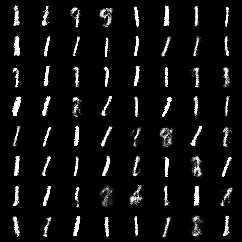



Train Epoch: 17 [0/60000 (0%)]	Generator Loss: 3.277166	Discriminator Loss: 0.283902
Train Epoch: 17 [12800/60000 (21%)]	Generator Loss: 3.509771	Discriminator Loss: 0.335306
Train Epoch: 17 [25600/60000 (43%)]	Generator Loss: 3.445888	Discriminator Loss: 0.238423
Train Epoch: 17 [38400/60000 (64%)]	Generator Loss: 3.684184	Discriminator Loss: 0.397400
Train Epoch: 17 [51200/60000 (85%)]	Generator Loss: 3.622043	Discriminator Loss: 0.241863
Test Epoch: 17 [0/10000 (0%)]	Generator Loss: 3.550273	Discriminator Loss: 0.325382
Sample of generated images


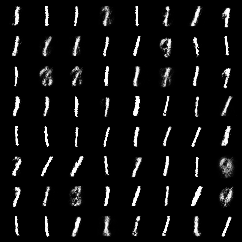



Train Epoch: 18 [0/60000 (0%)]	Generator Loss: 3.683609	Discriminator Loss: 0.225781
Train Epoch: 18 [12800/60000 (21%)]	Generator Loss: 3.516315	Discriminator Loss: 0.352178
Train Epoch: 18 [25600/60000 (43%)]	Generator Loss: 3.450138	Discriminator Loss: 0.414265
Train Epoch: 18 [38400/60000 (64%)]	Generator Loss: 3.631791	Discriminator Loss: 0.315134
Train Epoch: 18 [51200/60000 (85%)]	Generator Loss: 3.431653	Discriminator Loss: 0.239650
Test Epoch: 18 [0/10000 (0%)]	Generator Loss: 3.754456	Discriminator Loss: 0.237125
Sample of generated images


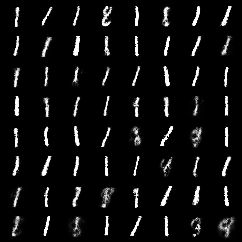



Train Epoch: 19 [0/60000 (0%)]	Generator Loss: 4.179543	Discriminator Loss: 0.219902
Train Epoch: 19 [12800/60000 (21%)]	Generator Loss: 3.029608	Discriminator Loss: 0.338742
Train Epoch: 19 [25600/60000 (43%)]	Generator Loss: 3.376069	Discriminator Loss: 0.315704
Train Epoch: 19 [38400/60000 (64%)]	Generator Loss: 3.157169	Discriminator Loss: 0.360966
Train Epoch: 19 [51200/60000 (85%)]	Generator Loss: 3.060521	Discriminator Loss: 0.294984
Test Epoch: 19 [0/10000 (0%)]	Generator Loss: 2.767282	Discriminator Loss: 0.332960
Sample of generated images


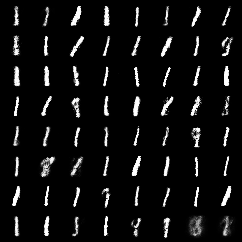



Train Epoch: 20 [0/60000 (0%)]	Generator Loss: 2.754533	Discriminator Loss: 0.425618
Train Epoch: 20 [12800/60000 (21%)]	Generator Loss: 2.911459	Discriminator Loss: 0.343802
Train Epoch: 20 [25600/60000 (43%)]	Generator Loss: 3.250154	Discriminator Loss: 0.179465
Train Epoch: 20 [38400/60000 (64%)]	Generator Loss: 2.973813	Discriminator Loss: 0.275414
Train Epoch: 20 [51200/60000 (85%)]	Generator Loss: 3.040265	Discriminator Loss: 0.439811
Test Epoch: 20 [0/10000 (0%)]	Generator Loss: 4.063614	Discriminator Loss: 0.511251
Sample of generated images


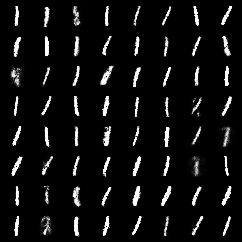



Train Epoch: 21 [0/60000 (0%)]	Generator Loss: 4.204572	Discriminator Loss: 0.312288
Train Epoch: 21 [12800/60000 (21%)]	Generator Loss: 3.162838	Discriminator Loss: 0.458375
Train Epoch: 21 [25600/60000 (43%)]	Generator Loss: 3.455726	Discriminator Loss: 0.378064
Train Epoch: 21 [38400/60000 (64%)]	Generator Loss: 3.054759	Discriminator Loss: 0.335846
Train Epoch: 21 [51200/60000 (85%)]	Generator Loss: 3.655624	Discriminator Loss: 0.177674
Test Epoch: 21 [0/10000 (0%)]	Generator Loss: 3.570072	Discriminator Loss: 0.375551
Sample of generated images


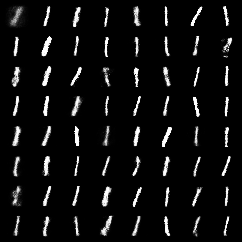



Train Epoch: 22 [0/60000 (0%)]	Generator Loss: 3.506379	Discriminator Loss: 0.303363
Train Epoch: 22 [12800/60000 (21%)]	Generator Loss: 3.931876	Discriminator Loss: 0.265022
Train Epoch: 22 [25600/60000 (43%)]	Generator Loss: 3.676241	Discriminator Loss: 0.223466
Train Epoch: 22 [38400/60000 (64%)]	Generator Loss: 3.771029	Discriminator Loss: 0.232331
Train Epoch: 22 [51200/60000 (85%)]	Generator Loss: 3.616247	Discriminator Loss: 0.251253
Test Epoch: 22 [0/10000 (0%)]	Generator Loss: 3.470729	Discriminator Loss: 0.356515
Sample of generated images


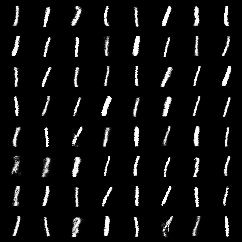



Train Epoch: 23 [0/60000 (0%)]	Generator Loss: 3.746115	Discriminator Loss: 0.358770
Train Epoch: 23 [12800/60000 (21%)]	Generator Loss: 3.273074	Discriminator Loss: 0.215616
Train Epoch: 23 [25600/60000 (43%)]	Generator Loss: 3.582788	Discriminator Loss: 0.374407
Train Epoch: 23 [38400/60000 (64%)]	Generator Loss: 3.306617	Discriminator Loss: 0.283513
Train Epoch: 23 [51200/60000 (85%)]	Generator Loss: 2.722469	Discriminator Loss: 0.374127
Test Epoch: 23 [0/10000 (0%)]	Generator Loss: 3.058149	Discriminator Loss: 0.246230
Sample of generated images


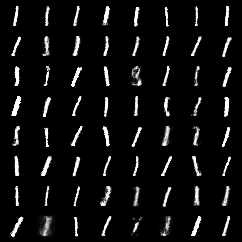



Train Epoch: 24 [0/60000 (0%)]	Generator Loss: 3.064772	Discriminator Loss: 0.300729
Train Epoch: 24 [12800/60000 (21%)]	Generator Loss: 3.518898	Discriminator Loss: 0.262239
Train Epoch: 24 [25600/60000 (43%)]	Generator Loss: 3.140162	Discriminator Loss: 0.216557
Train Epoch: 24 [38400/60000 (64%)]	Generator Loss: 3.933870	Discriminator Loss: 0.252387
Train Epoch: 24 [51200/60000 (85%)]	Generator Loss: 3.222104	Discriminator Loss: 0.360222
Test Epoch: 24 [0/10000 (0%)]	Generator Loss: 3.516057	Discriminator Loss: 0.472180
Sample of generated images


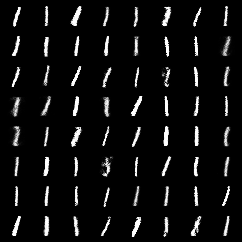



Train Epoch: 25 [0/60000 (0%)]	Generator Loss: 3.538795	Discriminator Loss: 0.397572
Train Epoch: 25 [12800/60000 (21%)]	Generator Loss: 2.739592	Discriminator Loss: 0.340427
Train Epoch: 25 [25600/60000 (43%)]	Generator Loss: 3.734952	Discriminator Loss: 0.425270
Train Epoch: 25 [38400/60000 (64%)]	Generator Loss: 2.761350	Discriminator Loss: 0.376565
Train Epoch: 25 [51200/60000 (85%)]	Generator Loss: 2.530117	Discriminator Loss: 0.394325
Test Epoch: 25 [0/10000 (0%)]	Generator Loss: 2.691453	Discriminator Loss: 0.236273
Sample of generated images


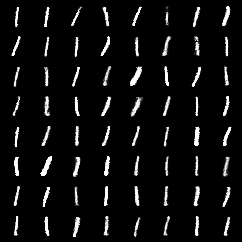



Train Epoch: 26 [0/60000 (0%)]	Generator Loss: 2.921979	Discriminator Loss: 0.314120
Train Epoch: 26 [12800/60000 (21%)]	Generator Loss: 2.927284	Discriminator Loss: 0.364389
Train Epoch: 26 [25600/60000 (43%)]	Generator Loss: 3.038333	Discriminator Loss: 0.350908
Train Epoch: 26 [38400/60000 (64%)]	Generator Loss: 2.793867	Discriminator Loss: 0.366086
Train Epoch: 26 [51200/60000 (85%)]	Generator Loss: 2.697829	Discriminator Loss: 0.352258
Test Epoch: 26 [0/10000 (0%)]	Generator Loss: 2.758705	Discriminator Loss: 0.295391
Sample of generated images


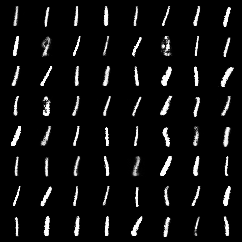



Train Epoch: 27 [0/60000 (0%)]	Generator Loss: 3.281751	Discriminator Loss: 0.251407
Train Epoch: 27 [12800/60000 (21%)]	Generator Loss: 3.734082	Discriminator Loss: 0.213293
Train Epoch: 27 [25600/60000 (43%)]	Generator Loss: 3.071734	Discriminator Loss: 0.374887
Train Epoch: 27 [38400/60000 (64%)]	Generator Loss: 3.148707	Discriminator Loss: 0.370907
Train Epoch: 27 [51200/60000 (85%)]	Generator Loss: 3.696761	Discriminator Loss: 0.360989
Test Epoch: 27 [0/10000 (0%)]	Generator Loss: 3.074766	Discriminator Loss: 0.239707
Sample of generated images


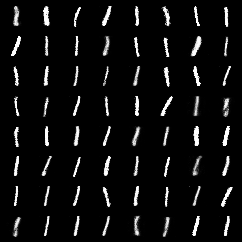



Train Epoch: 28 [0/60000 (0%)]	Generator Loss: 3.074891	Discriminator Loss: 0.310884
Train Epoch: 28 [12800/60000 (21%)]	Generator Loss: 3.078253	Discriminator Loss: 0.293817
Train Epoch: 28 [25600/60000 (43%)]	Generator Loss: 3.334643	Discriminator Loss: 0.320515
Train Epoch: 28 [38400/60000 (64%)]	Generator Loss: 2.921786	Discriminator Loss: 0.305370
Train Epoch: 28 [51200/60000 (85%)]	Generator Loss: 2.792037	Discriminator Loss: 0.358840
Test Epoch: 28 [0/10000 (0%)]	Generator Loss: 2.392200	Discriminator Loss: 0.228286
Sample of generated images


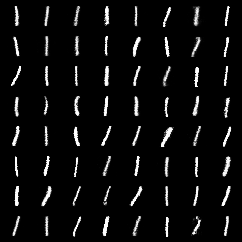



Train Epoch: 29 [0/60000 (0%)]	Generator Loss: 2.787328	Discriminator Loss: 0.249616
Train Epoch: 29 [12800/60000 (21%)]	Generator Loss: 2.933586	Discriminator Loss: 0.273876
Train Epoch: 29 [25600/60000 (43%)]	Generator Loss: 2.548081	Discriminator Loss: 0.373283
Train Epoch: 29 [38400/60000 (64%)]	Generator Loss: 3.083949	Discriminator Loss: 0.325745
Train Epoch: 29 [51200/60000 (85%)]	Generator Loss: 3.466457	Discriminator Loss: 0.332924
Test Epoch: 29 [0/10000 (0%)]	Generator Loss: 2.872505	Discriminator Loss: 0.292983
Sample of generated images


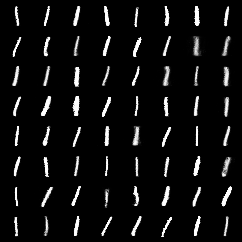



Train Epoch: 30 [0/60000 (0%)]	Generator Loss: 2.913758	Discriminator Loss: 0.416703
Train Epoch: 30 [12800/60000 (21%)]	Generator Loss: 3.664208	Discriminator Loss: 0.173504
Train Epoch: 30 [25600/60000 (43%)]	Generator Loss: 2.781352	Discriminator Loss: 0.295017
Train Epoch: 30 [38400/60000 (64%)]	Generator Loss: 3.293884	Discriminator Loss: 0.285306
Train Epoch: 30 [51200/60000 (85%)]	Generator Loss: 2.912663	Discriminator Loss: 0.181626
Test Epoch: 30 [0/10000 (0%)]	Generator Loss: 3.206744	Discriminator Loss: 0.226949
Sample of generated images


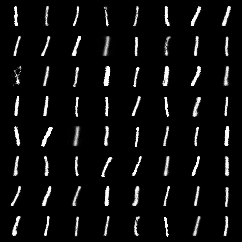



Train Epoch: 31 [0/60000 (0%)]	Generator Loss: 3.422210	Discriminator Loss: 0.342272
Train Epoch: 31 [12800/60000 (21%)]	Generator Loss: 3.188821	Discriminator Loss: 0.265712
Train Epoch: 31 [25600/60000 (43%)]	Generator Loss: 2.700346	Discriminator Loss: 0.332604
Train Epoch: 31 [38400/60000 (64%)]	Generator Loss: 3.111716	Discriminator Loss: 0.218817
Train Epoch: 31 [51200/60000 (85%)]	Generator Loss: 2.810105	Discriminator Loss: 0.289429
Test Epoch: 31 [0/10000 (0%)]	Generator Loss: 3.097963	Discriminator Loss: 0.456922
Sample of generated images


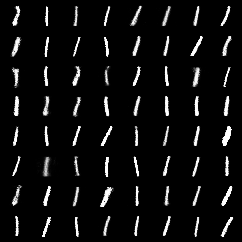



Train Epoch: 32 [0/60000 (0%)]	Generator Loss: 3.152282	Discriminator Loss: 0.302309
Train Epoch: 32 [12800/60000 (21%)]	Generator Loss: 3.029899	Discriminator Loss: 0.303230
Train Epoch: 32 [25600/60000 (43%)]	Generator Loss: 2.664974	Discriminator Loss: 0.323605
Train Epoch: 32 [38400/60000 (64%)]	Generator Loss: 3.214179	Discriminator Loss: 0.306990
Train Epoch: 32 [51200/60000 (85%)]	Generator Loss: 2.863435	Discriminator Loss: 0.469171
Test Epoch: 32 [0/10000 (0%)]	Generator Loss: 2.682827	Discriminator Loss: 0.266133
Sample of generated images


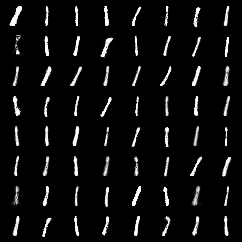



Train Epoch: 33 [0/60000 (0%)]	Generator Loss: 3.094068	Discriminator Loss: 0.235220
Train Epoch: 33 [12800/60000 (21%)]	Generator Loss: 2.453128	Discriminator Loss: 0.345466
Train Epoch: 33 [25600/60000 (43%)]	Generator Loss: 3.262470	Discriminator Loss: 0.335028
Train Epoch: 33 [38400/60000 (64%)]	Generator Loss: 3.360677	Discriminator Loss: 0.139487
Train Epoch: 33 [51200/60000 (85%)]	Generator Loss: 2.707006	Discriminator Loss: 0.275659
Test Epoch: 33 [0/10000 (0%)]	Generator Loss: 2.446412	Discriminator Loss: 0.276142
Sample of generated images


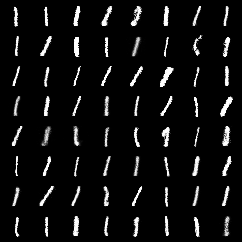



Train Epoch: 34 [0/60000 (0%)]	Generator Loss: 2.794892	Discriminator Loss: 0.264004
Train Epoch: 34 [12800/60000 (21%)]	Generator Loss: 2.801953	Discriminator Loss: 0.222661
Train Epoch: 34 [25600/60000 (43%)]	Generator Loss: 2.544940	Discriminator Loss: 0.268523
Train Epoch: 34 [38400/60000 (64%)]	Generator Loss: 3.378509	Discriminator Loss: 0.268678
Train Epoch: 34 [51200/60000 (85%)]	Generator Loss: 3.329924	Discriminator Loss: 0.217292
Test Epoch: 34 [0/10000 (0%)]	Generator Loss: 3.071148	Discriminator Loss: 0.313695
Sample of generated images


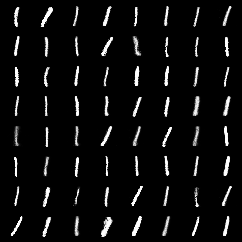



Train Epoch: 35 [0/60000 (0%)]	Generator Loss: 3.225234	Discriminator Loss: 0.254164
Train Epoch: 35 [12800/60000 (21%)]	Generator Loss: 3.105155	Discriminator Loss: 0.381882
Train Epoch: 35 [25600/60000 (43%)]	Generator Loss: 2.530925	Discriminator Loss: 0.222055
Train Epoch: 35 [38400/60000 (64%)]	Generator Loss: 3.210286	Discriminator Loss: 0.353240
Train Epoch: 35 [51200/60000 (85%)]	Generator Loss: 3.282047	Discriminator Loss: 0.323881
Test Epoch: 35 [0/10000 (0%)]	Generator Loss: 2.892257	Discriminator Loss: 0.378456
Sample of generated images


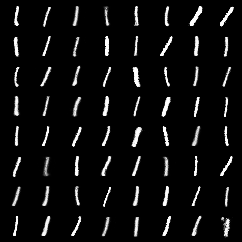



Train Epoch: 36 [0/60000 (0%)]	Generator Loss: 2.718381	Discriminator Loss: 0.371953
Train Epoch: 36 [12800/60000 (21%)]	Generator Loss: 3.266848	Discriminator Loss: 0.256865
Train Epoch: 36 [25600/60000 (43%)]	Generator Loss: 3.327852	Discriminator Loss: 0.226667
Train Epoch: 36 [38400/60000 (64%)]	Generator Loss: 2.640511	Discriminator Loss: 0.374944
Train Epoch: 36 [51200/60000 (85%)]	Generator Loss: 2.764199	Discriminator Loss: 0.281557
Test Epoch: 36 [0/10000 (0%)]	Generator Loss: 2.736613	Discriminator Loss: 0.277196
Sample of generated images


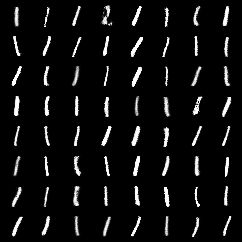



Train Epoch: 37 [0/60000 (0%)]	Generator Loss: 3.042034	Discriminator Loss: 0.270050
Train Epoch: 37 [12800/60000 (21%)]	Generator Loss: 2.885136	Discriminator Loss: 0.182017
Train Epoch: 37 [25600/60000 (43%)]	Generator Loss: 3.315822	Discriminator Loss: 0.317399
Train Epoch: 37 [38400/60000 (64%)]	Generator Loss: 2.603582	Discriminator Loss: 0.296938
Train Epoch: 37 [51200/60000 (85%)]	Generator Loss: 3.041677	Discriminator Loss: 0.357814
Test Epoch: 37 [0/10000 (0%)]	Generator Loss: 2.597279	Discriminator Loss: 0.276124
Sample of generated images


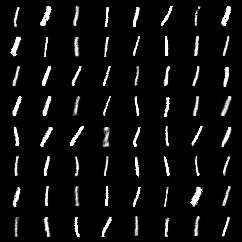



Train Epoch: 38 [0/60000 (0%)]	Generator Loss: 2.618744	Discriminator Loss: 0.354789
Train Epoch: 38 [12800/60000 (21%)]	Generator Loss: 3.329706	Discriminator Loss: 0.260740
Train Epoch: 38 [25600/60000 (43%)]	Generator Loss: 2.471871	Discriminator Loss: 0.342828
Train Epoch: 38 [38400/60000 (64%)]	Generator Loss: 2.999666	Discriminator Loss: 0.262810
Train Epoch: 38 [51200/60000 (85%)]	Generator Loss: 3.070548	Discriminator Loss: 0.266858
Test Epoch: 38 [0/10000 (0%)]	Generator Loss: 3.065632	Discriminator Loss: 0.363149
Sample of generated images


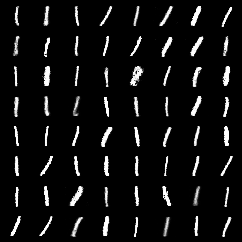



Train Epoch: 39 [0/60000 (0%)]	Generator Loss: 2.947491	Discriminator Loss: 0.382938
Train Epoch: 39 [12800/60000 (21%)]	Generator Loss: 3.443835	Discriminator Loss: 0.338109
Train Epoch: 39 [25600/60000 (43%)]	Generator Loss: 2.358120	Discriminator Loss: 0.413095
Train Epoch: 39 [38400/60000 (64%)]	Generator Loss: 2.810174	Discriminator Loss: 0.368970
Train Epoch: 39 [51200/60000 (85%)]	Generator Loss: 3.075486	Discriminator Loss: 0.324103
Test Epoch: 39 [0/10000 (0%)]	Generator Loss: 2.745923	Discriminator Loss: 0.278557
Sample of generated images


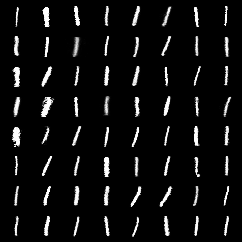



Train Epoch: 40 [0/60000 (0%)]	Generator Loss: 3.034449	Discriminator Loss: 0.293488
Train Epoch: 40 [12800/60000 (21%)]	Generator Loss: 2.740991	Discriminator Loss: 0.422026
Train Epoch: 40 [25600/60000 (43%)]	Generator Loss: 2.936308	Discriminator Loss: 0.233134
Train Epoch: 40 [38400/60000 (64%)]	Generator Loss: 3.033641	Discriminator Loss: 0.251823
Train Epoch: 40 [51200/60000 (85%)]	Generator Loss: 2.924627	Discriminator Loss: 0.362890
Test Epoch: 40 [0/10000 (0%)]	Generator Loss: 2.410992	Discriminator Loss: 0.251611
Sample of generated images


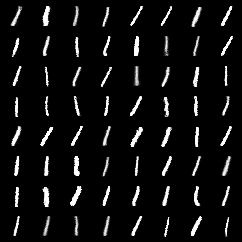



Train Epoch: 41 [0/60000 (0%)]	Generator Loss: 2.479107	Discriminator Loss: 0.321797
Train Epoch: 41 [12800/60000 (21%)]	Generator Loss: 2.671177	Discriminator Loss: 0.328422
Train Epoch: 41 [25600/60000 (43%)]	Generator Loss: 3.123324	Discriminator Loss: 0.305316
Train Epoch: 41 [38400/60000 (64%)]	Generator Loss: 3.226656	Discriminator Loss: 0.244290
Train Epoch: 41 [51200/60000 (85%)]	Generator Loss: 3.352701	Discriminator Loss: 0.383760
Test Epoch: 41 [0/10000 (0%)]	Generator Loss: 3.211109	Discriminator Loss: 0.288285
Sample of generated images


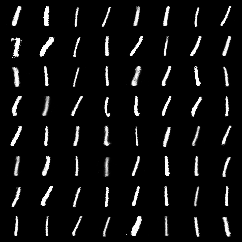



Train Epoch: 42 [0/60000 (0%)]	Generator Loss: 3.225920	Discriminator Loss: 0.195322
Train Epoch: 42 [12800/60000 (21%)]	Generator Loss: 2.778403	Discriminator Loss: 0.463831
Train Epoch: 42 [25600/60000 (43%)]	Generator Loss: 3.526791	Discriminator Loss: 0.174385
Train Epoch: 42 [38400/60000 (64%)]	Generator Loss: 2.936468	Discriminator Loss: 0.323529
Train Epoch: 42 [51200/60000 (85%)]	Generator Loss: 3.397166	Discriminator Loss: 0.312561
Test Epoch: 42 [0/10000 (0%)]	Generator Loss: 2.356377	Discriminator Loss: 0.348046
Sample of generated images


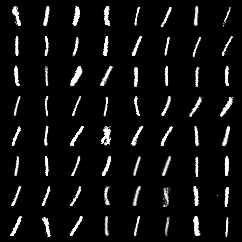



Train Epoch: 43 [0/60000 (0%)]	Generator Loss: 2.593801	Discriminator Loss: 0.272652
Train Epoch: 43 [12800/60000 (21%)]	Generator Loss: 2.850810	Discriminator Loss: 0.370602
Train Epoch: 43 [25600/60000 (43%)]	Generator Loss: 2.996562	Discriminator Loss: 0.345286
Train Epoch: 43 [38400/60000 (64%)]	Generator Loss: 2.900787	Discriminator Loss: 0.344719
Train Epoch: 43 [51200/60000 (85%)]	Generator Loss: 2.818315	Discriminator Loss: 0.315122
Test Epoch: 43 [0/10000 (0%)]	Generator Loss: 2.885528	Discriminator Loss: 0.456285
Sample of generated images


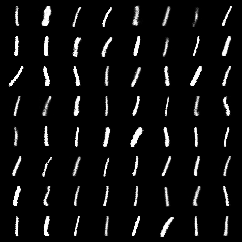



Train Epoch: 44 [0/60000 (0%)]	Generator Loss: 2.999741	Discriminator Loss: 0.326977
Train Epoch: 44 [12800/60000 (21%)]	Generator Loss: 2.927299	Discriminator Loss: 0.237723
Train Epoch: 44 [25600/60000 (43%)]	Generator Loss: 2.778209	Discriminator Loss: 0.307205
Train Epoch: 44 [38400/60000 (64%)]	Generator Loss: 2.796098	Discriminator Loss: 0.326050
Train Epoch: 44 [51200/60000 (85%)]	Generator Loss: 2.966363	Discriminator Loss: 0.354034
Test Epoch: 44 [0/10000 (0%)]	Generator Loss: 2.769560	Discriminator Loss: 0.397862
Sample of generated images


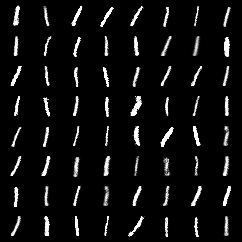



Train Epoch: 45 [0/60000 (0%)]	Generator Loss: 2.762258	Discriminator Loss: 0.427354
Train Epoch: 45 [12800/60000 (21%)]	Generator Loss: 2.991377	Discriminator Loss: 0.344956
Train Epoch: 45 [25600/60000 (43%)]	Generator Loss: 2.856711	Discriminator Loss: 0.198516
Train Epoch: 45 [38400/60000 (64%)]	Generator Loss: 2.714641	Discriminator Loss: 0.269837
Train Epoch: 45 [51200/60000 (85%)]	Generator Loss: 3.247367	Discriminator Loss: 0.208754
Test Epoch: 45 [0/10000 (0%)]	Generator Loss: 2.977865	Discriminator Loss: 0.416334
Sample of generated images


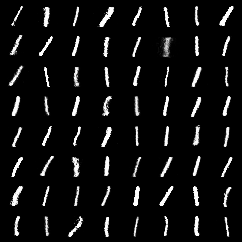



Train Epoch: 46 [0/60000 (0%)]	Generator Loss: 2.995157	Discriminator Loss: 0.425203
Train Epoch: 46 [12800/60000 (21%)]	Generator Loss: 2.487586	Discriminator Loss: 0.438838
Train Epoch: 46 [25600/60000 (43%)]	Generator Loss: 2.895233	Discriminator Loss: 0.285891
Train Epoch: 46 [38400/60000 (64%)]	Generator Loss: 3.004660	Discriminator Loss: 0.263137
Train Epoch: 46 [51200/60000 (85%)]	Generator Loss: 3.116976	Discriminator Loss: 0.334008
Test Epoch: 46 [0/10000 (0%)]	Generator Loss: 2.246565	Discriminator Loss: 0.445069
Sample of generated images


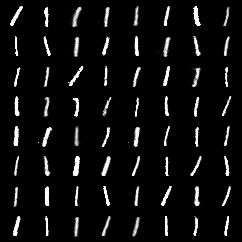



Train Epoch: 47 [0/60000 (0%)]	Generator Loss: 2.570098	Discriminator Loss: 0.352733
Train Epoch: 47 [12800/60000 (21%)]	Generator Loss: 3.465510	Discriminator Loss: 0.292449
Train Epoch: 47 [25600/60000 (43%)]	Generator Loss: 2.775493	Discriminator Loss: 0.244067
Train Epoch: 47 [38400/60000 (64%)]	Generator Loss: 2.948098	Discriminator Loss: 0.400233
Train Epoch: 47 [51200/60000 (85%)]	Generator Loss: 2.626350	Discriminator Loss: 0.379248
Test Epoch: 47 [0/10000 (0%)]	Generator Loss: 3.115009	Discriminator Loss: 0.456172
Sample of generated images


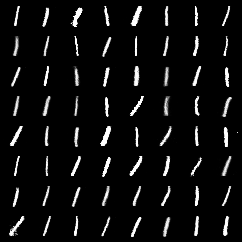



Train Epoch: 48 [0/60000 (0%)]	Generator Loss: 3.045763	Discriminator Loss: 0.299980
Train Epoch: 48 [12800/60000 (21%)]	Generator Loss: 2.846202	Discriminator Loss: 0.320309
Train Epoch: 48 [25600/60000 (43%)]	Generator Loss: 3.028209	Discriminator Loss: 0.303966
Train Epoch: 48 [38400/60000 (64%)]	Generator Loss: 2.868892	Discriminator Loss: 0.298236
Train Epoch: 48 [51200/60000 (85%)]	Generator Loss: 2.963083	Discriminator Loss: 0.280974
Test Epoch: 48 [0/10000 (0%)]	Generator Loss: 2.803535	Discriminator Loss: 0.335293
Sample of generated images


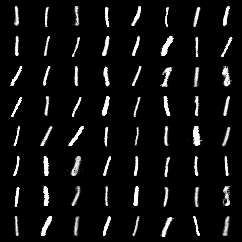



Train Epoch: 49 [0/60000 (0%)]	Generator Loss: 2.964916	Discriminator Loss: 0.331212
Train Epoch: 49 [12800/60000 (21%)]	Generator Loss: 2.869003	Discriminator Loss: 0.279074
Train Epoch: 49 [25600/60000 (43%)]	Generator Loss: 2.628911	Discriminator Loss: 0.250802
Train Epoch: 49 [38400/60000 (64%)]	Generator Loss: 2.988061	Discriminator Loss: 0.502932
Train Epoch: 49 [51200/60000 (85%)]	Generator Loss: 2.793061	Discriminator Loss: 0.226600
Test Epoch: 49 [0/10000 (0%)]	Generator Loss: 2.803092	Discriminator Loss: 0.559746
Sample of generated images


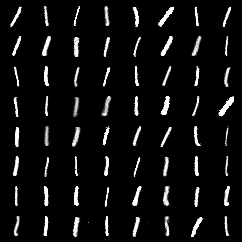



Train Epoch: 50 [0/60000 (0%)]	Generator Loss: 3.069955	Discriminator Loss: 0.233149
Train Epoch: 50 [12800/60000 (21%)]	Generator Loss: 2.629202	Discriminator Loss: 0.288655
Train Epoch: 50 [25600/60000 (43%)]	Generator Loss: 2.941608	Discriminator Loss: 0.275752
Train Epoch: 50 [38400/60000 (64%)]	Generator Loss: 2.869365	Discriminator Loss: 0.414482
Train Epoch: 50 [51200/60000 (85%)]	Generator Loss: 2.569880	Discriminator Loss: 0.347852
Test Epoch: 50 [0/10000 (0%)]	Generator Loss: 2.932814	Discriminator Loss: 0.471188
Sample of generated images


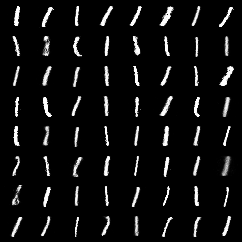

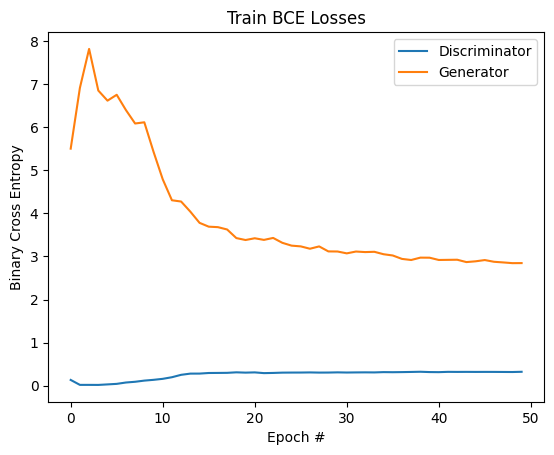

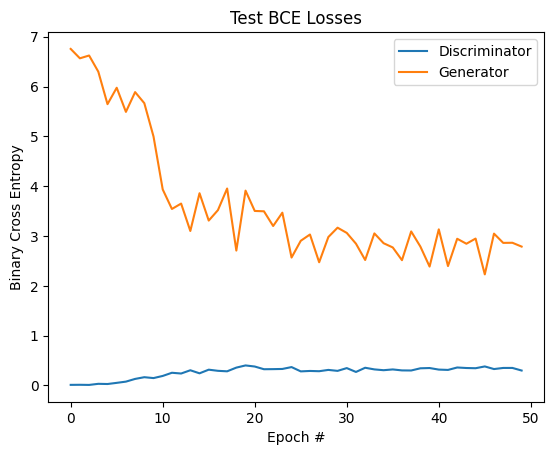

In [12]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


# Explanation of Results

Both VAEs and GANs generated high-quality images, but they approach the task in different ways.
The samples generated by VAEs are typically less detailed and more blurry than those generated by GANs, but they have a more diverse range of samples and can capture a broader range of variations in the input data.